# Matbench MP Gap — EDA, Featurization, Split, Preprocessing
Workflow:
1) Load dataset and save raw snapshot.
2) EDA figures (saved to ./slides).
3) Featurize (ElementFraction + Magpie) — per-sample, safe before split.
4) Grouped+Stratified split (by chemical system & target deciles).
5) Preprocess AFTER split (fit on Train only), scale.
6) Save artifacts (features, matrices, imputer/scaler, summaries) and diagnostic plots.

In [ ]:
import warnings, sys, time, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
np.random.seed(42)

def find_repo_root(max_up=5):
    p = Path.cwd()
    for _ in range(max_up):
        if (p / "src").is_dir() and (p / "notebooks").is_dir():
            return p
        p = p.parent
    return Path.cwd()

project_root = find_repo_root()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

from src.config import ART, SLIDES, RESULTS
from src.io_utils import save_np, save_df_pickle, save_json
from src.featurize import make_feature_matrix
from src.splits import strat_group_train_val_test, chemical_system
from src.plots import fig_bandgap_hist, fig_metal_fraction_by_nelems, fig_oxygen_violin

print("Repo root:", project_root)
print("Artifacts:", ART)
print("Slides:", SLIDES)

Repo root: /Users/elenei/Desktop/Brown/Data1030/final_project/bandgap/band_gap_project
Artifacts: /Users/elenei/Desktop/Brown/Data1030/final_project/bandgap/band_gap_project/artifacts
Slides: /Users/elenei/Desktop/Brown/Data1030/final_project/bandgap/band_gap_project/slides


In [5]:
from matminer.datasets import load_dataset

t0 = time.time()
df = load_dataset("matbench_mp_gap")  # downloads once, then caches
if "gap pbe" in df.columns and "band_gap_eV" not in df.columns:
    df = df.rename(columns={"gap pbe": "band_gap_eV"})
assert {"structure", "band_gap_eV"}.issubset(df.columns), df.columns.tolist()

save_df_pickle("raw_df.pkl", df[["structure", "band_gap_eV"]])
print(f"Loaded Matbench MP Gap: {len(df):,} rows in {time.time()-t0:.2f}s")
df.head(2)

Loaded Matbench MP Gap: 106,113 rows in 200.78s


,structure,band_gap_eV
0,"[[-0.00812638 0.02476014 -0.01698117] K, [-0....",1.3322
1,"[[0. 1.78463544 1.78463544] Cr, [1.784...",0.0000


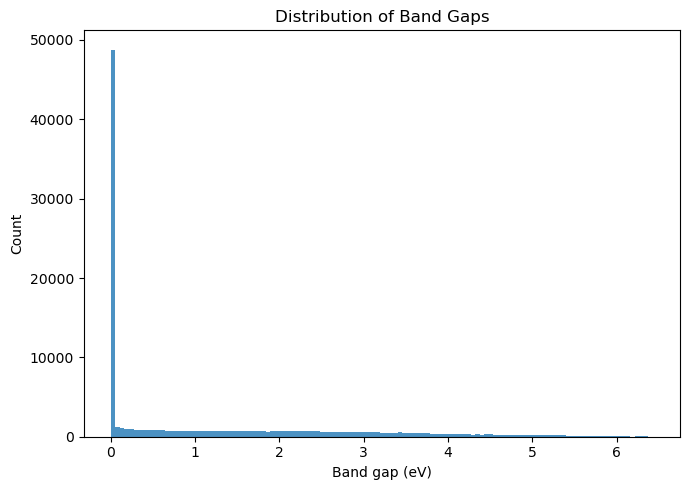

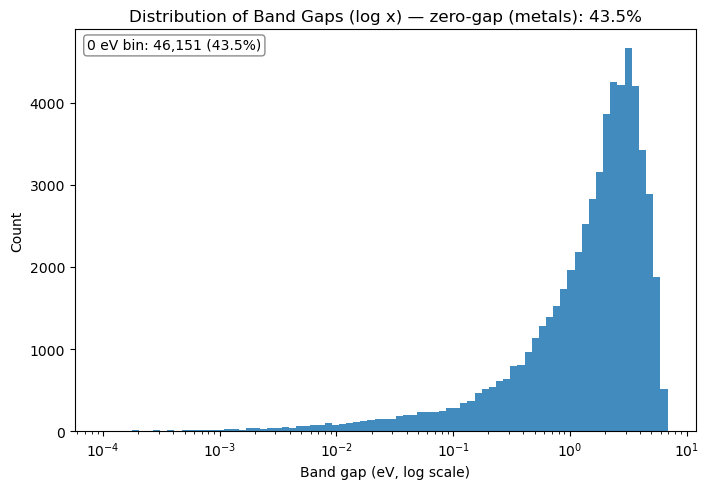

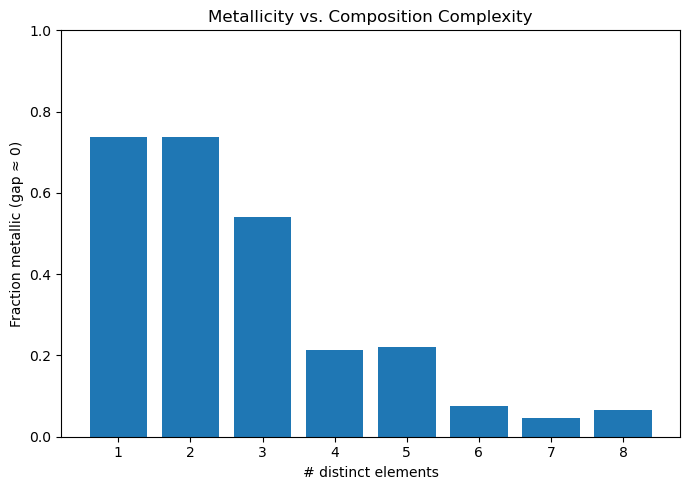

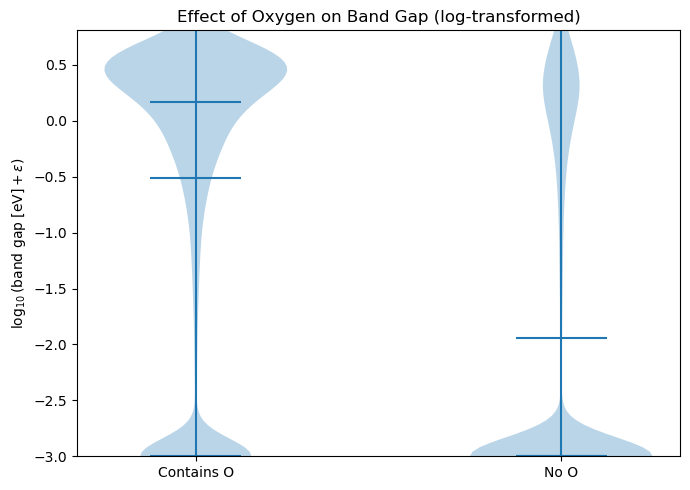

{'n_rows': 106113,
 'mean': 1.214626648007313,
 'std': 1.5989657899093914,
 'median': 0.27380000000000004,
 'q25': 0.0,
 'q75': 2.2075,
 'metal_fraction': 0.43492314796490533}

In [19]:
fig_bandgap_hist(df)     
fig_bandgap_hist_logx(df)            
fig_metal_fraction_by_nelems(df)    
fig_oxygen_violin_log(df)             

desc = df["band_gap_eV"].describe(percentiles=[.25,.5,.75]).to_dict()
eda_summary = {
    "n_rows": int(df.shape[0]),
    "mean": float(df["band_gap_eV"].mean()),
    "std": float(df["band_gap_eV"].std()),
    "median": float(df["band_gap_eV"].median()),
    "q25": float(desc["25%"]),
    "q75": float(desc["75%"]),
    "metal_fraction": float((df["band_gap_eV"] <= 1e-9).mean()),
}
save_json("eda_summary.json", eda_summary)
eda_summary

## Featurization

In [5]:
features_pickle = ART / "features_full.pkl"

if features_pickle.exists():
    print("Found features_full.pkl. Loading...")
    clean = pd.read_pickle(features_pickle)
else:
    print("Featurizing")
    t0 = time.time()
    clean = make_feature_matrix(df)  # uses src/featurize.py
    clean.to_pickle(features_pickle)
    print(f"Featurized: {clean.shape} in {time.time()-t0:.1f}s")

from pymatgen.core.periodic_table import Element
_symbols = {Element.from_Z(z).symbol for z in range(1, 119)}  # H..Og
_exclude = {"structure", "band_gap_eV", "composition", "__row_id__"}

feature_cols = [
    c for c in clean.columns
    if (
        c in _symbols or
        c.startswith(("frac ", "frac_")) or
        c.startswith(("MagpieData", "magpie"))
    ) and c not in _exclude
]

save_json("feature_columns.json", feature_cols)
print(f"EF={sum((c in _symbols) or c.startswith(('frac ','frac_')) for c in feature_cols)} | "
      f"Magpie={sum(c.startswith(('MagpieData','magpie')) for c in feature_cols)} | "
      f"Total={len(feature_cols)}")

Found features_full.pkl. Loading...
EF=118 | Magpie=132 | Total=250


## Grouped + stratified split (by chemical system & target deciles)

In [ ]:
train, val, test = strat_group_train_val_test(clean, test_frac=0.20, seed_outer=42, seed_inner=7)
print(f"Sizes → Train: {len(train):,} | Val: {len(val):,} | Test: {len(test):,}")

X_train_df = train[feature_cols].copy()
X_val_df   = val[feature_cols].copy()
X_test_df  = test[feature_cols].copy()

y_train = train["band_gap_eV"].to_numpy()
y_val   = val["band_gap_eV"].to_numpy()
y_test  = test["band_gap_eV"].to_numpy()

# Leakage check: systems do not overlap
sys_tr = set(train["structure"].apply(chemical_system))
sys_va = set(val["structure"].apply(chemical_system))
sys_te = set(test["structure"].apply(chemical_system))
print("Overlap systems →",
      f"Train∩Val={len(sys_tr & sys_va)} |",
      f"Train∩Test={len(sys_tr & sys_te)} |",
      f"Val∩Test={len(sys_va & sys_te)}")

Sizes → Train: 66,403 | Val: 17,545 | Test: 22,165
Overlap systems → Train∩Val=0 | Train∩Test=0 | Val∩Test=0


In [7]:
from src.save_splits import save_splits_csv_json
manifest = save_splits_csv_json(train, val, test, feature_cols, ART, chemical_system)
print("Saved splits →", manifest)

Saved splits → {'n_features': 250, 'sizes': {'train': 66403, 'val': 17545, 'test': 22165}, 'csv_files': ['train.csv', 'val.csv', 'test.csv'], 'json_files': ['train_with_structure.json', 'val_with_structure.json', 'test_with_structure.json']}


## Preprocessing

### Missing Data

In [ ]:
from src.preprocess import report_missingness
from src.io_utils import save_json
import pandas as pd

miss_report = report_missingness(
    {"train": X_train_df, "val": X_val_df, "test": X_test_df},
    per_feature_on="train",
    top_k=20
)
save_json("missing_report.json", miss_report)

# Optional CSV for quick browsing of per-feature train missingness
pd.Series(miss_report["train"]["per_feature_missing_rate"]).sort_values(ascending=False) \
  .to_csv(RESULTS / "missing_per_feature_train.csv")

print("Saved → artifacts/missing_report.json")
print("Saved → results/missing_per_feature_train.csv")
print({k: round(v["frac_rows_with_any_missing"],4) for k,v in miss_report.items()})

Saved → artifacts/missing_report.json
Saved → results/missing_per_feature_train.csv
{'train': 0.0, 'val': 0.0, 'test': 0.0}


#### zeroes

In [21]:
zero_frac = (X_train_df == 0).sum() / len(X_train_df)
zero_cols = zero_frac[zero_frac > 0].sort_values(ascending=False)
print(f"{len(zero_cols)} columns contain at least one zero.")
zero_cols.head(15)

206 columns contain at least one zero.


Rf    1.0
Sg    1.0
Lr    1.0
No    1.0
Md    1.0
Fm    1.0
Es    1.0
Cf    1.0
Bk    1.0
Cm    1.0
Am    1.0
Kr    1.0
Ra    1.0
Fr    1.0
Rn    1.0
dtype: float64

In [22]:
ef_zeros = [c for c in zero_cols.index if not c.startswith("MagpieData")]
mag_zeros = [c for c in zero_cols.index if c.startswith("MagpieData")]

print(f"ElementFraction zeros: {len(ef_zeros)}")
print(f"MagpieData zeros: {len(mag_zeros)}")

ElementFraction zeros: 118
MagpieData zeros: 88


In [ ]:
# Zero-counts by column (train), separated EF vs Magpie
import pandas as pd
import numpy as np

n_rows = len(X_train_df)


zero_counts = (X_train_df == 0).sum()

is_mag = X_train_df.columns.str.startswith("MagpieData")
is_ef  = ~is_mag  


ef_zero_cols  = zero_counts.index[(zero_counts > 0) & is_ef]
mag_zero_cols = zero_counts.index[(zero_counts > 0) & is_mag]

ef_summary = (
    pd.DataFrame({
        "column": ef_zero_cols,
        "zero_count": zero_counts[ef_zero_cols].values,
    })
    .assign(zero_fraction=lambda d: d["zero_count"] / n_rows)
    .sort_values("zero_fraction", ascending=False)
)

mag_summary = (
    pd.DataFrame({
        "column": mag_zero_cols,
        "zero_count": zero_counts[mag_zero_cols].values,
    })
    .assign(zero_fraction=lambda d: d["zero_count"] / n_rows)
    .sort_values("zero_fraction", ascending=False)
)

ef_zero_list  = ef_summary["column"].tolist()
mag_zero_list = mag_summary["column"].tolist()

# print quick summaries
print(f"ElementFraction zeros: {len(ef_zero_list)} / {int(is_ef.sum())} EF features")
print(ef_summary.head(15).to_string(index=False))

print(f"\nMagpieData zeros: {len(mag_zero_list)} / {int(is_mag.sum())} Magpie features")
print(mag_summary.head(15).to_string(index=False))

# save to results
ef_summary.to_csv(RESULTS / "zeros_ef_train.csv", index=False)
mag_summary.to_csv(RESULTS / "zeros_magpie_train.csv", index=False)
print("\nSaved → results/zeros_ef_train.csv and results/zeros_magpie_train.csv")

ElementFraction zeros: 118 / 118 EF features
column  zero_count  zero_fraction
    Og       66403            1.0
    Cf       66403            1.0
    Lr       66403            1.0
    Xe       66403            1.0
    No       66403            1.0
    Md       66403            1.0
    Fm       66403            1.0
    Es       66403            1.0
    Bk       66403            1.0
    Ar       66403            1.0
    Cm       66403            1.0
    Am       66403            1.0
    Po       66403            1.0
    At       66403            1.0
    Rn       66403            1.0

MagpieData zeros: 88 / 132 Magpie features
                       column  zero_count  zero_fraction
  MagpieData minimum GSmagmom       66322       0.998780
MagpieData minimum NfUnfilled       66214       0.997154
MagpieData minimum NsUnfilled       66141       0.996054
 MagpieData minimum GSbandgap       65922       0.992756
 MagpieData minimum NfValence       65529       0.986838
MagpieData minimum NdUnfi

In [26]:
import numpy as np
import pandas as pd

n_rows = len(X_train_df)

# constant-by-value (all zeros or same constant)
zero_var_mask = X_train_df.apply(lambda s: s.nunique(dropna=False) == 1, axis=0)
zero_var_cols = X_train_df.columns[zero_var_mask].tolist()

all_zero_cols = X_train_df.columns[(X_train_df == 0).all(axis=0)].tolist()

print("Zero-variance columns (any constant):", len(zero_var_cols))
print("All-zero columns:", len(all_zero_cols))
print("First few zero-variance:", zero_var_cols[:100])

Zero-variance columns (any constant): 34
All-zero columns: 34
First few zero-variance: ['He', 'Ne', 'Ar', 'Kr', 'Xe', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm', 'Md', 'No', 'Lr', 'Rf', 'Db', 'Sg', 'Bh', 'Hs', 'Mt', 'Ds', 'Rg', 'Cn', 'Nh', 'Fl', 'Mc', 'Lv', 'Ts', 'Og']


In [25]:
is_mag = X_train_df.columns.str.startswith("MagpieData")
const_ef  = [c for c in zero_var_cols if not c.startswith("MagpieData")]
const_mag = [c for c in zero_var_cols if     c.startswith("MagpieData")]

pd.Series(const_ef).to_csv(RESULTS / "constant_EF_features.csv", index=False)
pd.Series(const_mag).to_csv(RESULTS / "constant_Magpie_features.csv", index=False)

print(f"Constant EF features: {len(const_ef)}")
print(f"Constant Magpie features: {len(const_mag)}")

Constant EF features: 34
Constant Magpie features: 0


In [ ]:
import numpy as np
import pandas as pd

n_rows = len(X_train_df)
is_mag = X_train_df.columns.str.startswith("MagpieData")
is_ef  = ~is_mag

zfrac = (X_train_df == 0).sum().div(n_rows)

summary = pd.DataFrame({
    "family": np.where(is_mag, "magpie", "ef"),
    "zero_fraction": zfrac.values
}, index=X_train_df.columns)

n_ef          = int(is_ef.sum())
n_mag         = int(is_mag.sum())
ef_any_zero   = int((summary.loc[is_ef, "zero_fraction"] > 0).sum())
ef_all_zero   = int((summary.loc[is_ef, "zero_fraction"] == 1.0).sum())
mag_any_zero  = int((summary.loc[is_mag, "zero_fraction"] > 0).sum())
mag_all_zero  = int((summary.loc[is_mag, "zero_fraction"] == 1.0).sum())

print({
    "EF: total": n_ef,
    "EF: any zero": ef_any_zero,
    "EF: all zero": ef_all_zero,
    "Magpie: total": n_mag,
    "Magpie: any zero": mag_any_zero,
    "Magpie: all zero": mag_all_zero,
})

{'EF: total': 118, 'EF: any zero': 118, 'EF: all zero': 34, 'Magpie: total': 132, 'Magpie: any zero': 88, 'Magpie: all zero': 0}


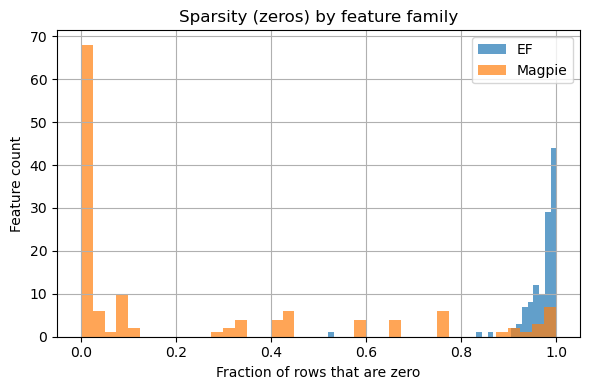

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
summary.loc[is_ef, "zero_fraction"].hist(bins=40, alpha=0.7, label="EF")
summary.loc[is_mag, "zero_fraction"].hist(bins=40, alpha=0.7, label="Magpie")
plt.xlabel("Fraction of rows that are zero"); plt.ylabel("Feature count")
plt.title("Sparsity (zeros) by feature family"); plt.legend(); plt.tight_layout()
plt.savefig(SLIDES / "fig_sparsity_hist.png", dpi=160)
plt.show()

### Scaling

In [ ]:
from src.preprocess import scale_only
from src.io_utils import save_np, save_json

X_train, X_val, X_test, feat_after, scaler = scale_only(X_train_df, X_val_df, X_test_df)

save_np("X_train.npy", X_train)
save_np("X_val.npy",   X_val)
save_np("X_test.npy",  X_test)
save_np("y_train.npy", y_train)
save_np("y_val.npy",   y_val)
save_np("y_test.npy",  y_test)
save_json("feature_columns_after_preprocess.json", feat_after)

print("Scaled shapes:",
      "X_train", X_train.shape, "| X_val", X_val.shape, "| X_test", X_test.shape)
print("Features before → after:", len(feature_cols), "→", len(feat_after), "(unchanged)")

Scaled shapes: X_train (66403, 250) | X_val (17545, 250) | X_test (22165, 250)
Features before → after: 250 → 250 (unchanged)


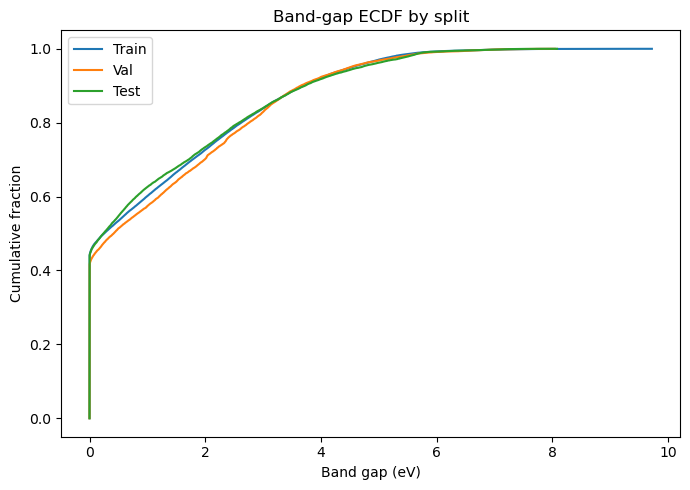

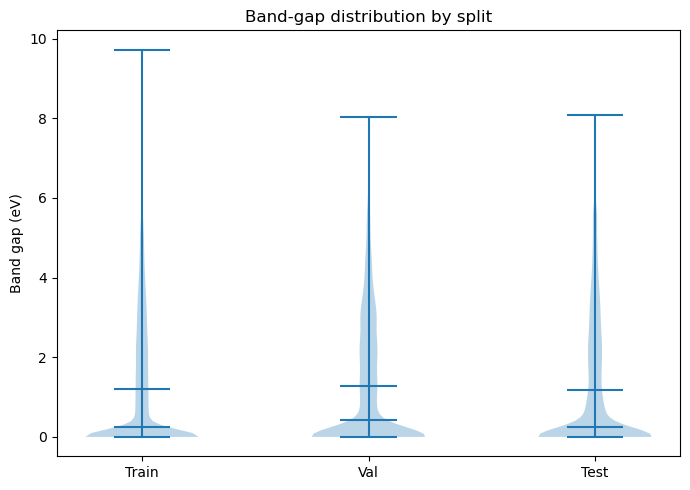

In [29]:
def ecdf(y):
    y = np.sort(y)
    x = np.linspace(0, 1, len(y))
    return y, x

yt, xt = ecdf(y_train); yv, xv = ecdf(y_val); ys, xs = ecdf(y_test)
plt.figure(figsize=(7,5))
plt.plot(yt, xt, label="Train")
plt.plot(yv, xv, label="Val")
plt.plot(ys, xs, label="Test")
plt.xlabel("Band gap (eV)"); plt.ylabel("Cumulative fraction")
plt.title("Band-gap ECDF by split")
plt.legend(); plt.tight_layout()
plt.savefig(SLIDES / "split_ecdf.png", dpi=200); plt.show()

plt.figure(figsize=(7,5))
plt.violinplot([y_train, y_val, y_test], showmeans=True, showextrema=True, showmedians=True)
plt.xticks([1,2,3], ["Train","Val","Test"])
plt.ylabel("Band gap (eV)")
plt.title("Band-gap distribution by split")
plt.tight_layout()
plt.savefig(SLIDES / "split_violin.png", dpi=200); plt.show()